# Exercise 4

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it
   
## Overview

In this exercise, you will simulate an experiment designed to measure the lifetime of an unstable particle X.  A beam of X particles is produced with a known average velocity and injected into a vacuum chamber.  Each X particle will travel some distance into the chamber before decaying at the so-called decay vertex, $r_{vtx}$.  The charged daughter particle is then detected by several tracking stations, located at various distances ($z_{stn}$) along the beam line.  Each tracking station measures the position where the track hits the station, $r_{hit}$.  By extrapolating back from the hit positions, the position of the decay vertex can be reconstructed.  Finally, the distribution of decay points, along with the known average beam velocity, can be used to estimate the mean lifetime of the X particle.

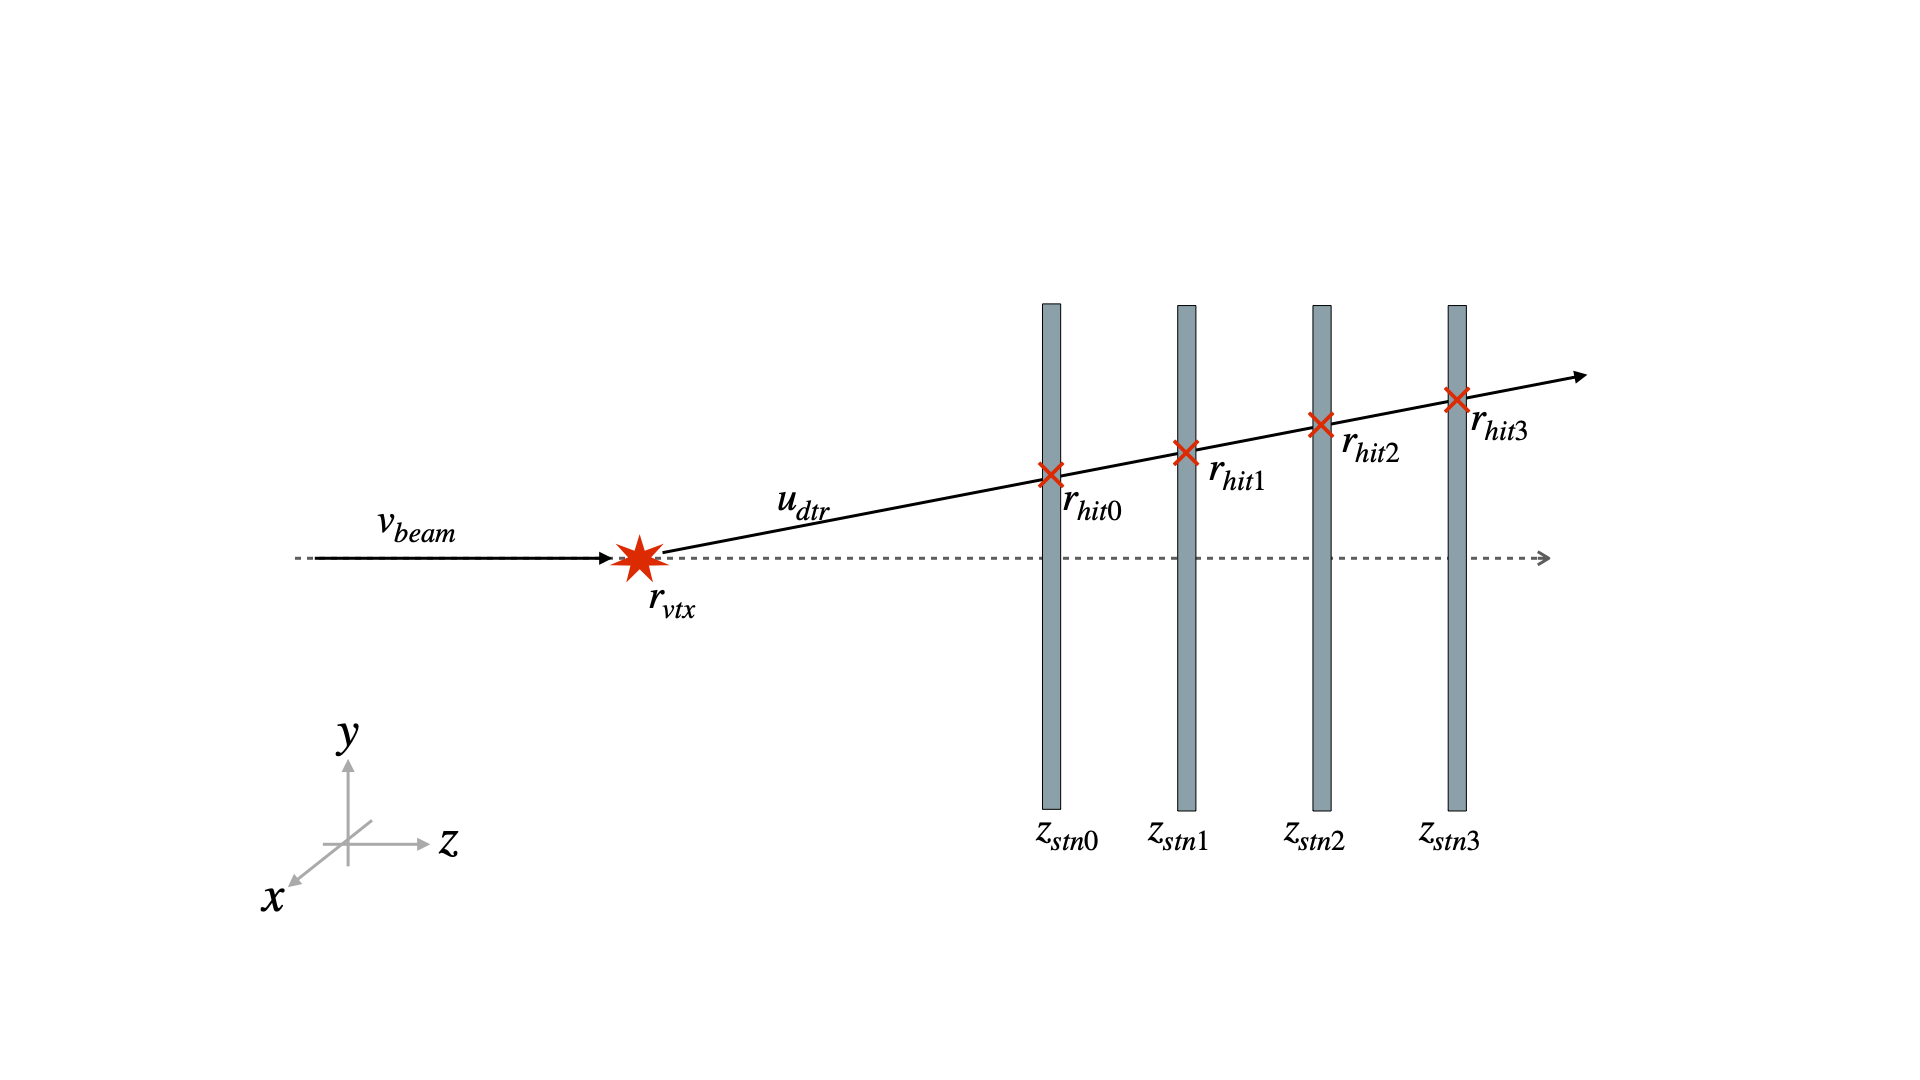

The coordinate system used below is shown in the diagram, where the beam is produced at the origin and travels in the $z$-direction.

You will use Monte Carlo methods to simulate the production, decay, and detection of particle X and it's daughter. Each part of the exercise simulates a different part of the experiment. By building up a set of functions, you will be able to simulate the full experiment.  You will then be able to simulate the experiment under different assumptions (eg. X mass, lifetime, beam parameters, tracking station positions, etc.) and make quantitative statements about how these assumptions influence the performance of the experiment.  It is strongly recommended that you use 3D vectors throughout the exercises, using numpy arrays, and numpy functions for vector algebra.

This exercise is deliberately open-ended.  A wide variety of extensions are possible, using all the topics covered in the unit.  If you are interested in exploring an extension, please discuss your plans with the unit director to ensure you efforts are well focussed.

## Part 1 - Beam Generation

First, you should simulate the production of beam particles.  Each particle in the beam will have a velocity in the z-direction, that is drawn from a normal distribution with mean $\mu_{v}$ and standard deviation $\sigma_{v}$.  The particle should decay after a time that is drawn from an exponential distribution with mean lifetime $\tau$.  Given the velocity and the decay time, the decay position in the lab frame should then be calculated.  You can assume the beam is non-relativistic.

In the cell below, write functions to simulate the beam velocity, the decay time, and the decay vertex.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math 



class Beam:
    def __init__(self, mean:float, st_dev:float, tau:float):
        self.mean = mean # mean of normal distribution
        self.st_dev = st_dev # standard deviation of normal distribution
        self.tau = tau #mean life time

    def b_vel(self):
        velarray = np.zeros(3)
        velarray[-1] = abs(np.random.normal(self.mean, self.st_dev))
        return velarray

    def decay(self):
        return np.random.exponential(self.tau)

    def vertex(self):
       return self.b_vel() * self.decay()
        


XPART= Beam(2000, 50, 2.5e-3) 


In the next cell, test your functions, and verify that they have the desired distributions.

Beam Velocity:  [   0.            0.         1987.64070973]
Decay Time:  0.00018181164044001055
Vertex Position:  [0.         0.         3.77463597]


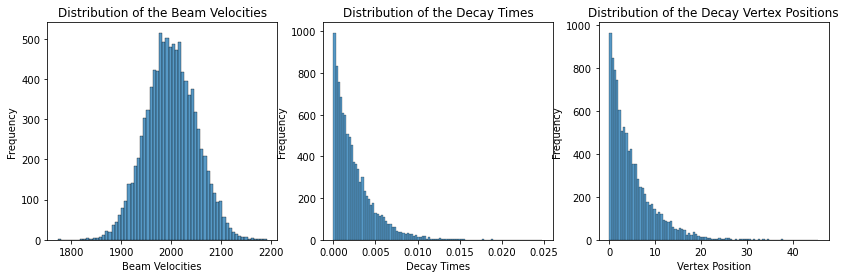

In [2]:
print("Beam Velocity: ", XPART.b_vel())
print("Decay Time: ", XPART.decay())
print("Vertex Position: ", XPART.vertex())

def distribution(n, Beam):

    fig, ax = plt.subplots(1, 3, figsize = (14, 4))
    times = [Beam.decay() for _ in range(n)]
    velocities = [Beam.b_vel()[2] for _ in range(n)]
    vertices = [Beam.vertex()[2] for _ in range(n)]

    sns.histplot(velocities, ax = ax[0])
    ax[0].set_xlabel('Beam Velocities')
    ax[0].set_ylabel("Frequency")
    ax[0].set_title("Distribution of the Beam Velocities")

    sns.histplot(times, ax = ax[1])
    ax[1].set_xlabel("Decay Times")
    ax[1].set_ylabel("Frequency")
    ax[1]. set_title("Distribution of the Decay Times")

    sns.histplot(vertices,ax = ax[2])
    ax[2].set_xlabel('Vertex Position')
    ax[2].set_ylabel("Frequency")
    ax[2].set_title("Distribution of the Decay Vertex Positions")

distribution(10000, XPART)

## Part 2 - Daughter Particle

Now simulate the direction of the decay product, which should be _isotropic_ in the rest frame of the beam particle. This is the same as generating points on the surface of a unit sphere, with uniform probability over the solid angle $d\Omega$. This can be achieved in spherical coordinates, by generating the two angles, $\phi$ and $\theta$.  These should not have uniform distributions, since the area element is given by :

$${\rm d}\Omega = \sin(\theta) {\rm d}\phi {\rm d}\theta$$

To obtain uniform probability over the sphere, you should generate $\phi$ with a uniform distribution between $0$ and $2\pi$, and $\theta$ with a distribution proportional to $\sin \theta$.

Note that the velocity of the daughter particle is not required in the base experiment, since we will assume the daughter follows a straight line track.  The direction vector we are producing here is equivalent to a unit vector in the direction of the daughter momentum, ie. $\frac{p_{dtr}}{|p_{dtr}|}$.

In the cell below, write functions which simulate the direction of the daughter particle in the rest frame of the beam particle, and the lab frame.

As for Part 1, in the next cell, test your functions and verify the desired distributions are produced.

In [63]:

# class Daughter():
#     def __init__(self, v_d):
#         self.v_d = v_d

def phi():
    return np.random.uniform(0, 2 * math.pi)

def sine(): # our distribution that is proportional to sine
    x= np.random.uniform(0, 1)
    return np.arccos(1 - x)

def frame_vectors(Beam, frame:str, v_d:float):
    x = np.cos(phi()) * sine() 
    y = np.sin(phi()) * sine() 
    z = np.random.uniform(-1, 1) 
    if frame == "Rest":
        pass
    elif frame == "Lab":
        x = x * v_d; y = y * v_d
        z = v_d * z + Beam.b_vel()[2]
    norm = np.sqrt((x**2 + y**2 + z**2))
    return np.array([x/norm, y/norm, z/norm]) 

# def sphere(): # in rest frame of daughter particle
#     # v = np.random.uniform(-1, 1)
#     # x = np.cos(phi()) * np.sqrt(1 - v**2)
#     # y = np.sin(phi()) * np.sqrt(1 - v**2)
#     z = np.random.uniform(-1, 1) 
#     norm = np.sqrt((x**2 + y**2 + z**2))
#     return np.array([x/norm, y/norm, z/norm])

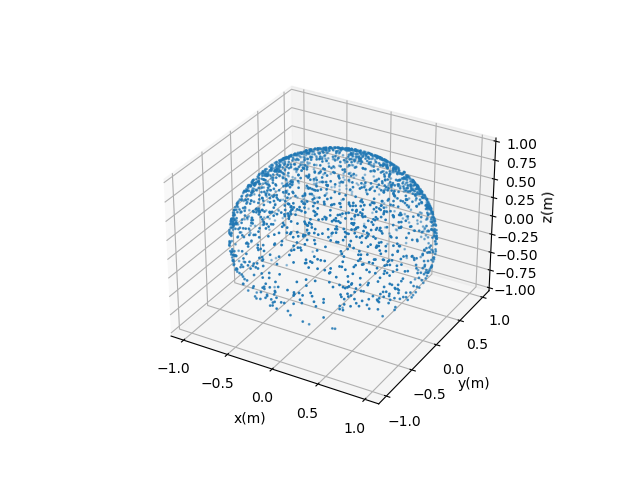

In [71]:
def plotting():
    n = 2000
    points = np.array([frame_vectors(XPART, "Lab", v_d = 3000) for _ in range(n)])
    ax = plt.axes(projection = '3d')
    ax.scatter3D(points[:, 0], points[:, 1], points[:, 2], s = 1)
    ax.set_xlabel('x(m)')
    ax.set_ylabel('y(m)')
    ax.set_zlabel(' z(m)')
    # ax.set_xlim3d(-1, 1)
    # ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    


%matplotlib widget

plotting()

## Part 3 - Propagation to Tracking Stations

The next step is to propagate the daughter particle to the tracking detectors. First, it is convenient to represent the track using a set of parameters. Here, the track is a straight line, which can be represented by 5 parameters :
  * $m_x = \frac{dx}{dz}$ - gradient in the $x$ direction
  * $m_y = \frac{dy}{dz}$ - gradient in the $y$ direction
  * $c_x$ - $x$-intercept at z=0
  * $c_y$ - $y$-intercept at z=0
  * $d$ - track direction (+1 for $+z$ direction, -1 for $-z$ direction)

In the cell below, write a function which calculates the track parameters from the decay vertex and daughter direction in the lab frame.

Then write another function which takes the track parameters, and computes the intercepts of the track with the tracking stations.  The function should accept a list of $z$ coordinates (one for each tracking station) and return the position $r_{hit}$ of the hit at each station.

Note that random numbers are not required for these functions.

In [5]:
# tracking functions

class Tracking(Beam):
    


In the next cell, test your track propagation functions. (A qualitative assessment is acceptable here).

In [6]:
# test code

## Part 4 - Hit Smearing

The tracking detectors are not perfect, and will measure position with some resolution.  This can be simulated by adding an offset to the true hit position, where the $x$ ($y$) offset is drawn from a normal distribution with a mean of zero and standard deviation $\sigma_{x}$ ($\sigma_{y}$), equal to the resolution of the detector in the $x$ ($y$) direction.  This process is known as smearing.

You should write a function which takes the true hit positions and smears them according to the detector resolution, to produce the reconstructed (or measure) hit positions.

In [7]:
# smearing function

Again, you should test your code to verify that the desire distributions are indeed produced.

In [8]:
# test code

## Part 5 - Track Reconstruction

In the real experiment, one would use the measured hits in tracking stations to "reconstruct" the track of the decay product.  You should perform the same process using the smeared hit positions. 

The location of the hits at the $i$-th tracking station can be written in terms of the track parameters $(m_x, m_y, c_x, c_y)$ and the $z$ position of the tracking station :

$$
\begin{pmatrix}
m_x \\
m_y
\end{pmatrix}
z_i
+
\begin{pmatrix}
c_x \\
c_y
\end{pmatrix}
=
\begin{pmatrix}
x_i \\
y_i
\end{pmatrix}
$$

For $N$ tracking stations, we have a set of $N$ such equations.  We can write these equations as a matrix equation  :
$$M j_{trk} = x_{hits}$$

Where $x_{hits}$ is vector containing all the measured hit coordinates, $j_{trk}$ is the track parameters, and $M$ is a matrix which depends on the tracking station positions.  For example, with 3 tracking stations, we have :

$$
\begin{pmatrix}
z_0 & 0   & 1 & 0 \\
0   & z_0 & 0 & 1 \\
z_1 & 0   & 1 & 0 \\ 
0   & z_1 & 0 & 1 \\
z_2 & 0   & 1 & 0 \\
0   & z_2 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
m_x \\
m_y \\
c_x \\
c_y
\end{pmatrix}
=
\begin{pmatrix}
x_0 \\
y_0 \\
x_1 \\
y_1 \\
x_2 \\
y_2
\end{pmatrix}
$$

The track parameters can be obtained by solving the matrix equation above.  When choosing an algorithm to solve the equation, note that there is almost certainly not an exact solution, due to the smearing of hit positions.  You should use an algorithm which will find the _closest_ solution.

In the cell below, write functions to first construct the matrix equation, and then to solve it.

In [9]:
# track reconstruction functions

In the cell below, test your code

In [10]:
# test code

## Part 6 - Vertex Reconstruction

The reconstructed track parameters can be used to estimate the orginal decay position. In the absence of mis-measurement, the $z$ position of the decay can be found from the intercept of the track and the $z$-axis. However, due to the finite detector resolution, the reconstructed track may not exactly intercept the $z$-axis.  Instead, you can use the point where the track is closest, in the $(x-y)$ plane, to the $z$-axis.

The distance from the track to the z-axis can be written :
$$r = \sqrt{x^2 + y^2} = \sqrt{(m_x z + c_x)^2 + (m_y z + c_y)^2}$$

This is a quadratic, $r^2 = a z^2 + b z + c$, where $a = m_x^2 +m_y^2$, $b = 2 (m_x c_x + m_y c_y)$ and $c = c_x^2 + c_y^2$.

By converting to quadratic standard form, we can obtain the value of $z$ where $r^2$ is a minimum :
$$z_{vtx} = - \frac{(m_x c_x + m_y c_y)}{m_x^2 +m_y^2}$$

In the cell below, write a function which uses this formula to calculate the vertex position from the reconstructed track parameters.

In [11]:
# vertex reconstruction functions

In the next cell, verify this function operates as desired.

In [12]:
# test code

## Part 7 - Full Experiment Simulation

Now you are ready to simulate the full experiment.  You should produce a large sample of events.  For each event, generate a beam particle, a daughter particle, the true and smeared hits, the reconstructed track and the reconstructed vertex.

Given a sample of events, it is possible to compute distributions of various quantities that will inform the design of the experiment.  You should present at least the following :
   * Number of tracking station hits
   * Difference between true and reconstructed decay vertex $z$-coordinate
   * Reconstructed decay vertex $z$-coordinate - which can be used to estimate the measured particle lifetime.

It can also be interesting to explore how these distributions change for different assumptions about the experimental setup, ie. the size, position and resolution of the tracking stations, and the true lifetime of X. As a starting point, you should assume the experiment aims to measure the lifetime of an unstable nucleus undergoing beta decay, with the following parameters :
   * X mean lifetime, $\tau = 2.5 {\rm ms}$
   * Mean X velocity, $\mu_v = 2000 {\rm ms}^{-1}$
   * Std dev X velocity, $\sigma_v = 50 {\rm ms}^{-1}$
   * Tracking station positions, $z_{stn} = 30, 35, 40, 45 {\rm m}$
   * Tracking hit resolution, $\sigma_{rx, ry} = 0.01 {\rm m}$
   * Daughter Particle Velocity, $ v_d = 1 \times 10^{7} {\rm ms}^{-1}$

In [13]:
# full experiment simulation 

In [14]:
# analysis code

## Part 8 - Discussion

In the markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained, and any conclusions. You are not expected to write more than 600-700 words, and you don't need to repeat information already given in the assignment.

 _Your discussion goes here_